# Solution

In [33]:
# put all python import statements here
import pandas as pd
import matplotlib.pyplot as plt
import solvers as slv
import numpy as np
from typing import Callable
import time

## Implementation

[First, write code to be able to solve the differential equations using the three methods you have chosen for arbitrary initial conditions ($y(t=0), v(t=0)$), time step and stopping time ($\mathrm{d}t$, $T$) and model parameters ($m, k, g$). Then, write code to solve the nonlinear problem for arbitrary $H$ and $T$, your three choices of differential equation solver and all the other differential equation solver parameters ($y(t=0), \mathrm{d}t, m, k, g$). [100 words]]

The diffrental equations used to model a firework are:
$$ \frac{d}{dt} y(t) = v(t) $$
$$ m \frac{d}{dt} v(t) = -k \big(v(t)\big)^2 - g $$

The first diffrental equation is fine by itself, however inorder to use the solver we must rearange the 2nd one such that only the first oder diffrental is on the left hand side. This allows us to proprely define the right hand side by defining it as: 
$$ \frac{d}{dt} v(t) = \frac{-k \cdot \left(v(t)\right)^2 - g}{m}$$

As there are 3 methods we are going to use for fireworks I simplfied their implementation by making it so that we can use them by chainging the method parameter of 1 function.

In [34]:
def fireworks(
    m: np.double,
    g: np.double,
    k: np.double,
    a: np.double,
    dt: np.double,
    T: np.double,
    method: str
):
    """
    Solves the differential equations used to model the firework.

    The problem is solved numerical using METHOD from t0 to T using a time step dt.

    Parameters
    ----------
    m
            The mass of the firework
    g
            The downard force due to gravity
    k
            The air restinece experienced by the firework
    a
            The intial upword velocity of the firework
    dt
            The time step
    T
            The final or stopping time
    method
            The method used to advance to solver. method should be one of:
            Heun, Ralston, Van De Houwen

    Returns
    -------
    t
            The time points where the solution was found
    y
            The estimate of the solution at each time point
    """

    #returns the right hand side of the diffrental equations
    def rhs(t: np.double, y: np.ndarray):
        return np.array([y[1],(-k*(y[1])**2 -g)/m])

    t, y = slv.solver(rhs, np.array([0.0, a]), 0.0,dt, T, method)

    return t,y

As we know the firework explodes at a fixed time T at height H we can model it as a nonlinear equation:
$$
F(a) = y(T; a) - H = 0
$$


In [35]:
def FireworksFunction(
    a: np.double,
    dt: np.double,
    method: str
):
    """
    Defines the nonlinear equation of the firework

    Parameters
    ----------
    a
            The intial upword velocity of the firework
    dt
            The time step

    method
            The method used to advance to solver. method should be one of:
            Heun, Ralston, Van De Houwen

    Returns
    -------
    Output
            The output of the firework function

    """
    CurrentT, CurrentY = fireworks(1.3,9.81,0.05,a,dt,1.5,method)
    Output = CurrentY[-1][0] -10

    return Output

The nonlinear solver's we have decied to test are the bisection method and the secant method due to their speed and accuracy.

In [36]:
def bisection(
    xl: np.double,
    xr: np.double,
    dt: np.double,
    method: np.double,
    TOL: np.double,
    Function: Callable[[np.double,np.double,str],np.double]
):
    """
    Finds the root of a function using the Bisection method.
    
    Parameters
    ----------
    xl  
        The lower bound of the initial interval.
        
    xr 
        The upper bound of the initial interval.
        
    dt 
        The time step 
        
    method 
                The method used to advance to solver. method should be one of:
                Heun, Ralston, Van De Houwen
    TOL : 
        The tolerance for convergence.
        
    Function : 
        The function for which the root is to be found.
    
    Returns
    -------
    midpoints : list of float
        The list of midpoint values calculated during each iteration. The final value is the approximation for the root.
    """


    midpoints = []
    Stop = False

    while Stop == False:

        #Calculate and store midpoints
        xc = (xl+xr)/2
        midpoints.append(xc)
    
        fc = Function(xc,dt,method)
        fl = Function(xl,dt,method)
        fr = Function(xr,dt,method)
        
        #If root is found stop
        if fc == 0:
            Stop = True
            
        #If there isn't a signficant change end
        if abs(xr - xl) < TOL:
            Stop = True
        #Iterate again depending on which side is closer to the root
        elif fl*fc < 0:
            xr = xc
    
        elif fc*fr < 0:
            xl = xc

    return midpoints


In [37]:
def secant(
    CurrentX: np.double,
    PrevX: np.double,
    dt: np.double,
    method: str,
    TOL: np.double,
    Function: Callable[[np.double,np.double,str],np.double]
):
    """
    Finds the root of a function using the Secant method.
    
    Parameters
    ----------
    CurrentX
        The current guess for the root.
        
    PrevX
        The previous guess for the root.
        
    dt
        The time step
        
    method
                The method used to advance to solver. method should be one of:
                Heun, Ralston, Van De Houwen
        
    TOL
        The tolerance for convergence, specifying the stopping criterion.
        
    Function
        The function for which the root is to be found. Must take three arguments: x (the value to evaluate), dt, and method.
    
    Returns
    -------
    approxs : list of float
        The list of approximation values calculated during each iteration. The final value is the approximation for the root.
    """   
    approxs = [CurrentX]
    dx = PrevX - CurrentX
    
    FCurrentX =  Function(CurrentX,dt,method)
    FPrevX = Function(PrevX,dt,method)

    while abs(FCurrentX) > TOL:
        NextX = CurrentX - FCurrentX * ((CurrentX - PrevX)/(FCurrentX -FPrevX))

        PrevX = CurrentX
        CurrentX = NextX
        approxs.append(CurrentX)

        FCurrentX =  Function(CurrentX,dt,method)
        FPrevX = Function(PrevX,dt,method)

    return approxs

## Results

[Simulate and show results for each of the test cases suggested by your boss for a range of time steps. For both test cases, you should use (at least) $\mathrm{d}t = T/100, T/200, T/400, T/800, T/1600$. You should demonstrate how solutions look for each method, and the accuracy and efficiency of each approach. [100 words]]

### Test Case A ###

In order to ensure that the diffrental equation solvers work, we can display the graph and table for the height and time of the firework.

In [38]:
#Names of the solvers to be used
SolverNames = ["Heun","Ralston","Van der Houwen"]
#TimeSteps to be used in test case a
TimeStepsA = [1/100,1/200,1/400,1/800,1/1600]
#TimeSteps to be used in test case b
TimeStepsB = [1.5/100,1.5/200,1.5/400,1.5/800,1.5/1600]

Current Method is: Heun


,Time,Height,Velocity
0,0.0,0.000000,15.000000
1,0.1,1.337500,12.184687
2,0.2,2.431735,9.971902
3,0.3,3.329206,8.156505
4,0.4,4.061592,6.613182
5,0.5,4.651044,5.260565
6,0.6,5.113263,4.042842
7,0.7,5.459375,2.919665
8,0.8,5.697079,1.860217
9,0.9,5.831371,0.839507


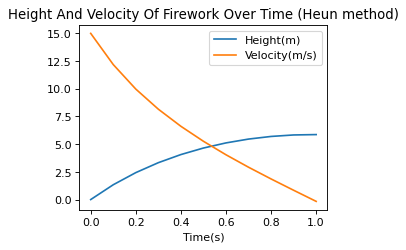

Current Method is: Ralston


,Time,Height,Velocity
0,0.0,0.000000,15.000000
1,0.1,1.337500,12.202292
2,0.2,2.433281,9.996393
3,0.3,3.332957,8.183646
4,0.4,4.067835,6.641276
5,0.5,4.659909,5.288994
6,0.6,5.124822,4.071485
7,0.7,5.473682,2.948649
8,0.8,5.714200,1.889816
9,0.9,5.851396,0.870099


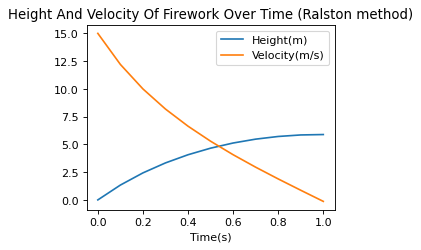

Current Method is: Van der Houwen


,Time,Height,Velocity
0,0.0,0.000000,15.000000
1,0.1,1.352870,12.163144
2,0.2,2.454753,9.944942
3,0.3,3.356060,8.129865
4,0.4,4.090271,6.588833
5,0.5,4.680426,5.239038
6,0.6,5.142696,4.024118
7,0.7,5.488458,2.903524
8,0.8,5.725546,1.846384
9,0.9,5.859027,0.827703


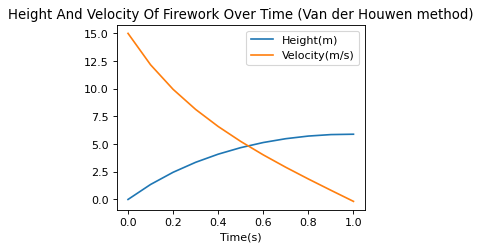

In [48]:
for method in SolverNames:
    print("Current Method is: " + method)
    
    CurrentTime, CurrentY = fireworks(1.0,10.0,0.1,15.0,0.1,1,method)
    CurrentHeight = []
    CurrentVelocity = []

    #Store the height and velocity at a current time
    for i in range(len(CurrentY)):
        CurrentHeight.append(CurrentY[i][0])
        CurrentVelocity.append(CurrentY[i][1])

    #Store the data within the dataframe
    CurrentDataset = {"Time":CurrentTime, "Height":CurrentHeight, "Velocity":CurrentVelocity}
    Table = pd.DataFrame(CurrentDataset)
    display(Table)

    #Display the graph
    plt.figure(figsize=(4, 3),dpi=80)
    plt.plot(CurrentTime, CurrentHeight , label = "Height(m)")
    plt.plot(CurrentTime, CurrentVelocity , label = "Velocity(m/s)")
    plt.xlabel("Time(s)")
    plt.title("Height And Velocity Of Firework Over Time (" + method + " method)")
    plt.legend()
    plt.show()


Both the graph and data in the table suggest that the diffrental solvers provide a reasonable output.

However to futher test the differnetal equations we will use test case a , in which we use the exact solution at t = 1 in order to comapre the error sizes and runtime between the methods.

,Method,Approximation,Relative Error,Absolute Error,Runtime
0,Heun,5.891586,3.547697e-05,2.090230e-04,0.001567
1,Ralston,5.891781,2.314095e-06,1.363417e-05,0.001568
2,Van der Houwen,5.891794,3.045567e-08,1.794386e-07,0.002366


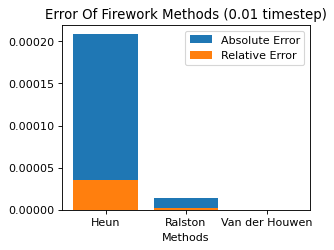

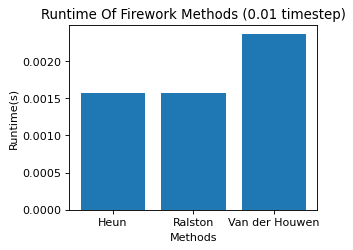

,Method,Approximation,Relative Error,Absolute Error,Runtime
0,Heun,5.891743,8.755671e-06,5.158661e-05,0.002963
1,Ralston,5.891791,5.409727e-07,3.187300e-06,0.002885
2,Van der Houwen,5.891795,3.831748e-09,2.257587e-08,0.004551


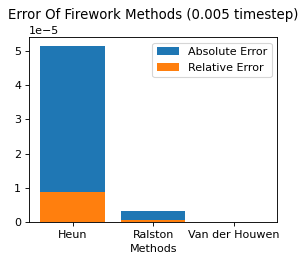

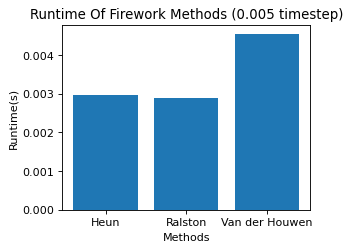

,Method,Approximation,Relative Error,Absolute Error,Runtime
0,Heun,5.891782,2.174957e-06,1.281440e-05,0.006728
1,Ralston,5.891794,1.307015e-07,7.700662e-07,0.005580
2,Van der Houwen,5.891795,4.804459e-10,2.830689e-09,0.009054


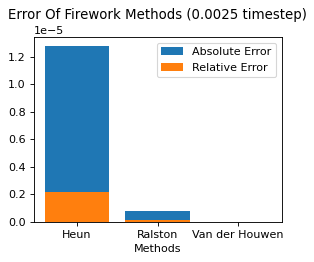

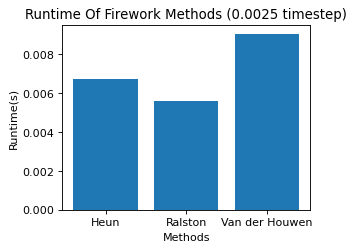

,Method,Approximation,Relative Error,Absolute Error,Runtime
0,Heun,5.891791,5.420086e-07,3.193404e-06,0.012250
1,Ralston,5.891794,3.211697e-08,1.892266e-07,0.011286
2,Van der Houwen,5.891795,6.014468e-11,3.543601e-10,0.018021


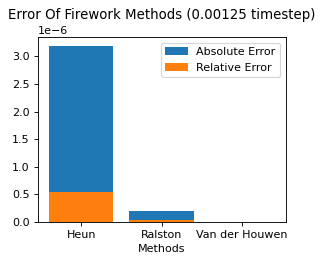

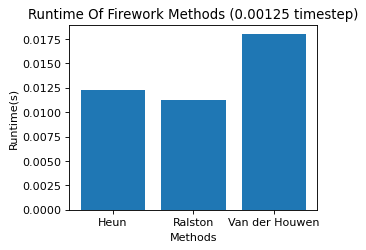

,Method,Approximation,Relative Error,Absolute Error,Runtime
0,Heun,5.891794,1.352867e-07,7.970817e-07,0.025320
1,Ralston,5.891795,7.960018e-09,4.689879e-08,0.022453
2,Van der Houwen,5.891795,7.525811e-12,4.434053e-11,0.036043


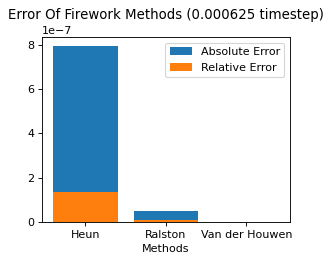

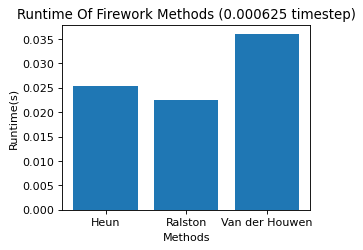

In [49]:
#Arrays used to store the reqs needed to produce the data vizulizations (table and graphs)
Approximates = {1/100:[],1/200:[],1/400:[] ,1/800:[],1/1600:[]}
ApproxRuntime = {1/100:[],1/200:[],1/400:[] ,1/800:[],1/1600:[]}
#Get the result of each method at diffrent timesteps
for method in SolverNames:
    for Step in TimeStepsA:
        start = time.time()
        CurrentTime, CurrentY = fireworks(1.0,10.0,0.1,15.0,Step,1.0,method)
        end = time.time()
        
        #Store the result of the current method in the approximates array
        Approximates[Step].append(CurrentY[-1][0])
        ApproxRuntime[Step].append(end - start)
    

for Step in TimeStepsA:
    AbsoluteErrors = []
    RelativeErrors = []
    CurrentApproxs = [Approximates[Step][0],Approximates[Step][1],Approximates[Step][2]]

    #Calculate the errors based on the actual value
    ActualVal = 5.891794628863073
    AbsoluteErrors.append(abs(Approximates[Step][0] - ActualVal))
    AbsoluteErrors.append(abs(Approximates[Step][1] - ActualVal))
    AbsoluteErrors.append(abs(Approximates[Step][2] - ActualVal))
    
    for z in range(3):
        RelativeErrors.append(abs(AbsoluteErrors[z])/abs(ActualVal))

    #Store errors within a dataframe
    ErrorDataset = {"Method":SolverNames, "Approximation":CurrentApproxs, "Relative Error":RelativeErrors , "Absolute Error":AbsoluteErrors , "Runtime":ApproxRuntime[Step] }
    ErrorTable = pd.DataFrame(ErrorDataset)

    #Display the table 
    display(ErrorTable)
    
    #Graph to display accuracy
    plt.figure(figsize=(4, 3),dpi=80)
    plt.bar(SolverNames, AbsoluteErrors , label = "Absolute Error")
    plt.bar(SolverNames, RelativeErrors , label = "Relative Error")
    plt.xlabel("Methods")
    plt.title("Error Of Firework Methods (" + str(Step) + " timestep)")
    plt.legend()
    plt.show()

    #Graph to display efficency
    plt.figure(figsize=(4, 3),dpi=80)
    plt.bar(SolverNames, ApproxRuntime[Step])
    plt.xlabel("Methods")
    plt.ylabel("Runtime(s)")
    plt.title("Runtime Of Firework Methods (" + str(Step) + " timestep)")
    plt.show()

We can now procede onto test case b, however before doing so we must ensure that our non linear solvers provide a reasonable output.

### Test Case B ###

Inorder to ensure that the methods are working we can test them with a function that we know the roots to being:
$$ f(x) = x^2 - 4
$$

In [41]:
def TestFunction(
    a: np.double,
    dt: np.double,
    method: str
):
    """
    Defines a simple nonlinear equation with known roots.

    The function is f(x) = x^2 - 4, which has roots at x = 2 and x = -2.
    """
    Output = a**2 - 4
    return Output

In [42]:
print(bisection(0.5,3.0,0.1,"Heun",np.double(1e-6) ,TestFunction)[-1])
print(bisection(-0.5,-3.0,0.1,"Heun",np.double(1e-6) ,TestFunction)[-1])

2.0000000596046448
-2.0000000596046448


In [43]:
print(secant(3.0,0.5,0.1,"Heun", np.double(1e-6) ,TestFunction)[-1])
print(secant(-3.0,-1.0,0.1,"Heun", np.double(1e-6) ,TestFunction)[-1])

2.0000000000550378
-1.9999999578600827


The outputs of both methods suggest that they're are working as they're both sufficently close to the actual roots at: $$ x = 2$$ and $$x =-2$$.

We can now start test case b in which we will attempt to find the root of : 
$$ F(a) = y(1.5; a) - 10.0 $$
making sure to compare the accuracy and efficency of the methods.

From our test function we can see that a tolerence of 1e-6 gives a sufficently accurate input as the ouput's precsion is comparable to the exact soloution we were given for test case a. 

However picking the intial guesses for the secant and bisection paramters will be difficult due to our limted knowledge. To counteract this I'll test for a higher explosion height so that I can establish a broader range to test for results

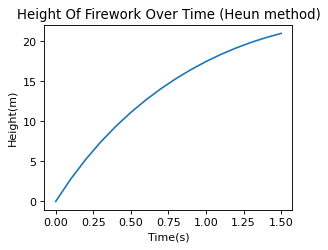

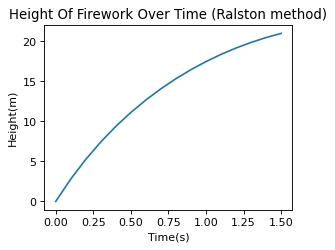

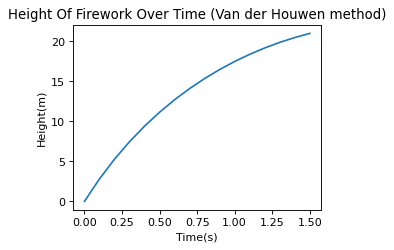

In [50]:
for method in SolverNames:
    CurrentTime, CurrentY = fireworks(1.3,9.81,0.05,30,0.1,1.5,method)
    CurrentHeight = []
    CurrentVelocity = []

    #Store the height and velocity at a current time
    for i in range(len(CurrentY)):
        CurrentHeight.append(CurrentY[i][0])

    #Display the graph
    plt.figure(figsize=(4, 3),dpi=80)
    plt.plot(CurrentTime, CurrentHeight )
    plt.xlabel("Time(s)")
    plt.ylabel("Height(m)")
    plt.title("Height Of Firework Over Time (" + method + " method)")
    plt.show()


As we can see from the graph the firework explodes above 20m which is sufficently bigger than our 10m ensuring that the root for the model of the firework that explodes at 10m would be within the range of 1 to the intial velocity we used for the 20m explosion being 30 m/s.

Thus, for the bisection method we have:  
$$
x_l = 1, \quad x_r = 30
$$

and for the secant method we have:  
$$
x_0 = 1, \quad x_1 = 30
$$

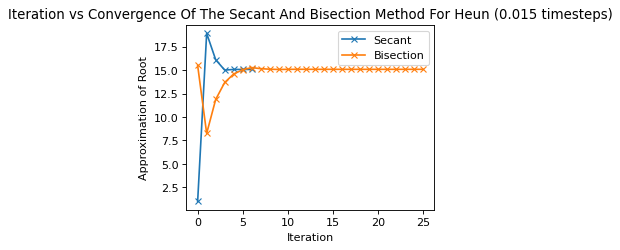

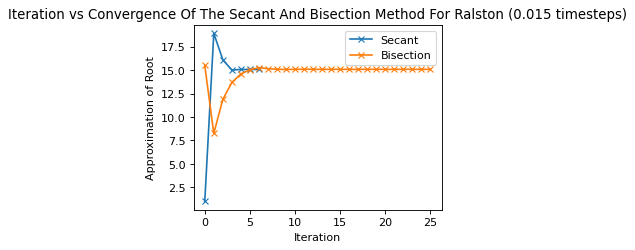

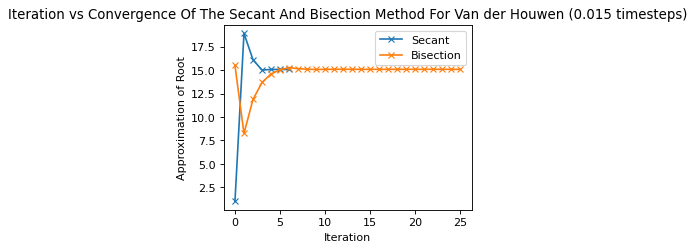

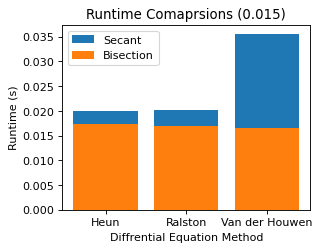

,Diffrental Method,Nonlinear Method,Root Approximation
0,Heun,Secant,15.076902
1,Heun,Bisection,15.091026
2,Ralston,Secant,15.076726
3,Ralston,Bisection,15.091026
4,Van der Houwen,Secant,15.076600
5,Van der Houwen,Bisection,15.091026


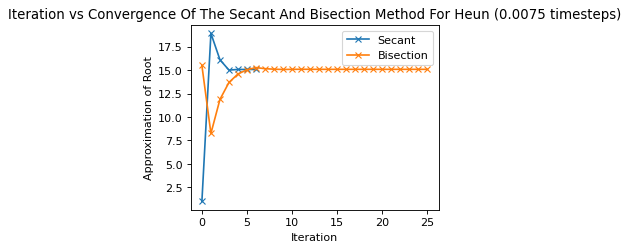

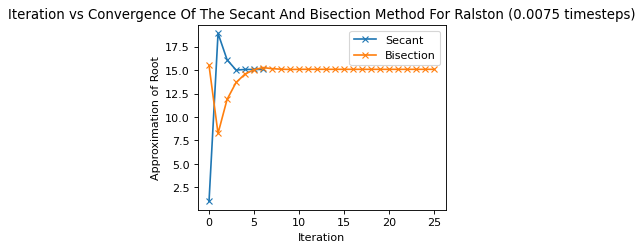

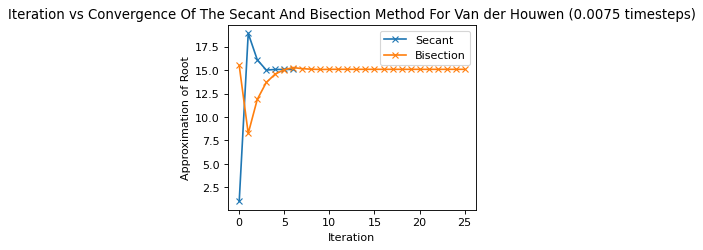

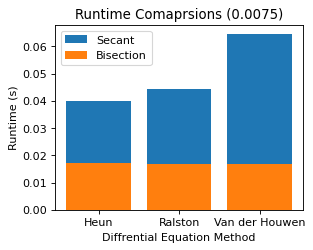

,Diffrental Method,Nonlinear Method,Root Approximation
0,Heun,Secant,15.076675
1,Heun,Bisection,15.091026
2,Ralston,Secant,15.076632
3,Ralston,Bisection,15.091026
4,Van der Houwen,Secant,15.076601
5,Van der Houwen,Bisection,15.091026


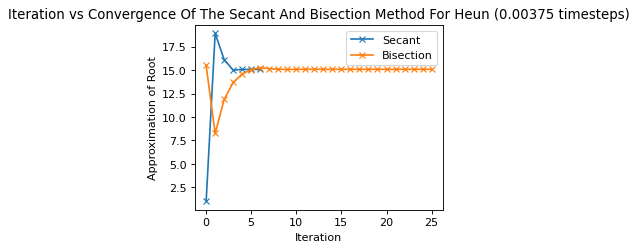

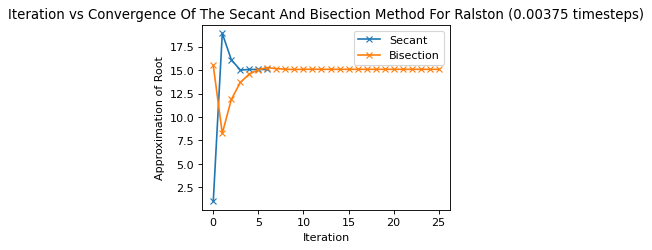

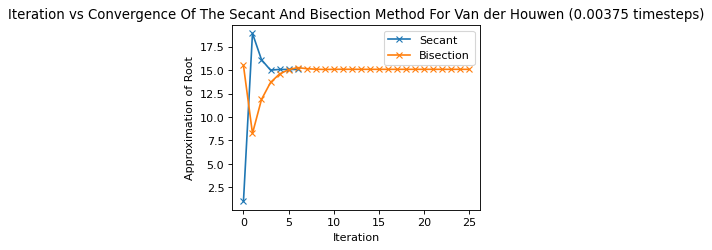

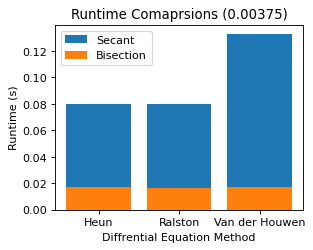

,Diffrental Method,Nonlinear Method,Root Approximation
0,Heun,Secant,15.076619
1,Heun,Bisection,15.091026
2,Ralston,Secant,15.076608
3,Ralston,Bisection,15.091026
4,Van der Houwen,Secant,15.076601
5,Van der Houwen,Bisection,15.091026


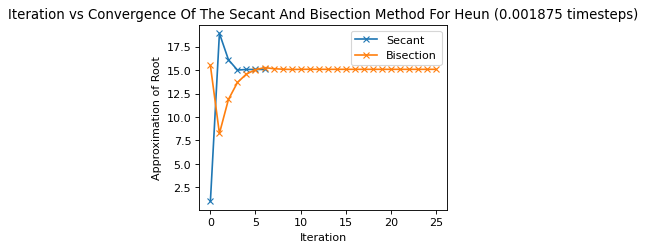

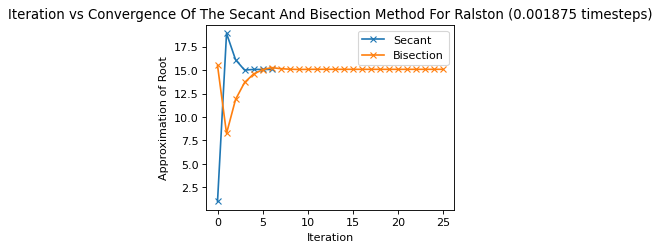

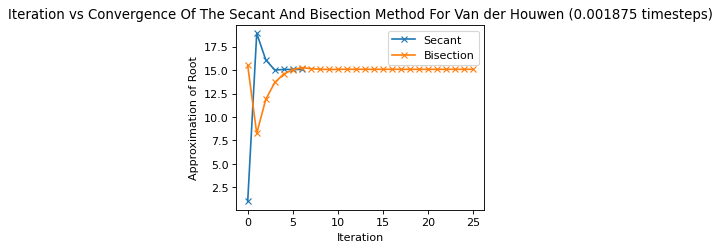

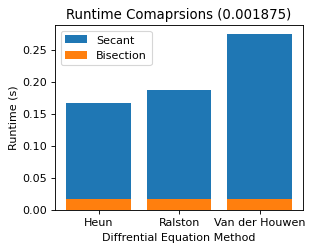

,Diffrental Method,Nonlinear Method,Root Approximation
0,Heun,Secant,15.076605
1,Heun,Bisection,15.091026
2,Ralston,Secant,15.076603
3,Ralston,Bisection,15.091026
4,Van der Houwen,Secant,15.076601
5,Van der Houwen,Bisection,15.091026


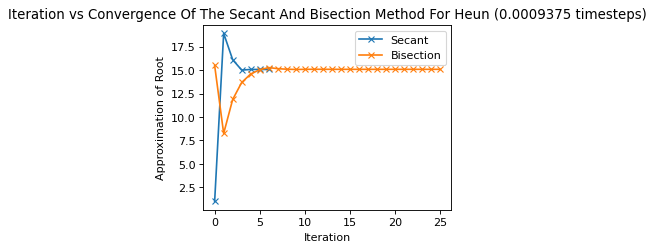

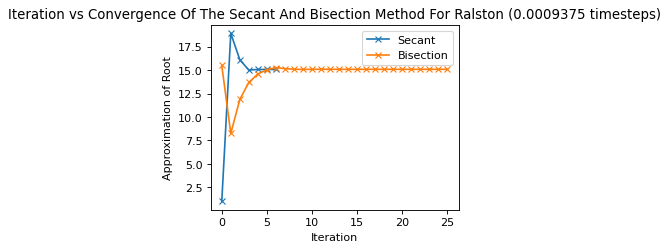

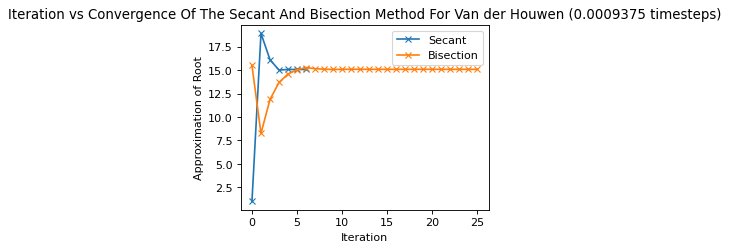

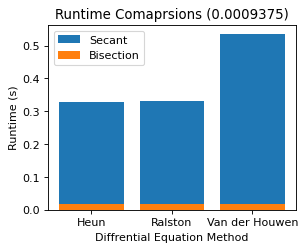

,Diffrental Method,Nonlinear Method,Root Approximation
0,Heun,Secant,15.076602
1,Heun,Bisection,15.091026
2,Ralston,Secant,15.076601
3,Ralston,Bisection,15.091026
4,Van der Houwen,Secant,15.076601
5,Van der Houwen,Bisection,15.091026


In [51]:
#Arrays used to store the reqs needed to produce the data vizulizations (table and graphs)
SecantApproxs = {1.5/100:[],1.5/200:[],1.5/400:[] ,1.5/800:[],1.5/1600:[]}
SecantRuntimes = {1.5/100:[],1.5/200:[],1.5/400:[] ,1.5/800:[],1.5/1600:[]}

BisectionApproxs = {1.5/100:[],1.5/200:[],1.5/400:[] ,1.5/800:[],1.5/1600:[]}
BisectionRuntimes = {1.5/100:[],1.5/200:[],1.5/400:[] ,1.5/800:[],1.5/1600:[]}

#Get the result of each method at diffrent timesteps
for method in SolverNames:
    for Step in TimeStepsB:
        #Get the result & runtime of the bisection method
        BisectionStart = time.time()
        BisectionOutput = bisection(1.0,30.0,0.1,"Heun",np.double(1e-6) ,FireworksFunction)
        BisectionEnd = time.time()

        #Store the result & runtime of the bisection method in it's approximates array
        BisectionApproxs[Step].append(BisectionOutput)
        BisectionRuntimes[Step].append(BisectionEnd - BisectionStart) 

        #Get the result & runtime of the secant method
        SecantStart = time.time()
        SecantOutput = secant(1.0,30.0,Step,method, np.double(1e-6) ,FireworksFunction)
        SecantEnd = time.time()

        #Store the result & runtime of the secamt method in it's approximates array
        SecantApproxs[Step].append(SecantOutput)
        SecantRuntimes[Step].append(SecantEnd - SecantStart)             
        
#Display the data vizulization of each method at diffrent timesteps
for Step in TimeStepsB:

    #Plots the convergence graph of each diffrental solver
    for i in range(len(SolverNames)):

        plt.figure(figsize=(4, 3),dpi=80)
        plt.plot(range(len(SecantApproxs[Step][i])), SecantApproxs[Step][i], marker='x', label="Secant")
        plt.plot(range(len(BisectionApproxs[Step][i])), BisectionApproxs[Step][i], marker='x', label="Bisection")
        plt.legend()
        plt.xlabel("Iteration")
        plt.ylabel("Approximation of Root")
        plt.title("Iteration vs Convergence Of The Secant And Bisection Method For " + SolverNames[i] + " (" + str(Step) + " timesteps)")
        plt.show()

    #Plots the runtime graph of each method 
    plt.figure(figsize=(4, 3),dpi=80)
    plt.bar(SolverNames,SecantRuntimes[Step],label = "Secant")
    plt.bar(SolverNames,BisectionRuntimes[Step],label = "Bisection")
    plt.legend()
    plt.xlabel("Diffrential Equation Method")
    plt.ylabel("Runtime (s)")
    plt.title("Runtime Comaprsions ("+ str(Step) + ")")
    plt.show()

    #Store the root approximations within a dataframe
    ValueDataset = {"Diffrental Method":[], "Nonlinear Method": [], "Root Approximation":[]}


    for j in range(3):
        ValueDataset["Diffrental Method"].append(SolverNames[j]) 
        ValueDataset["Nonlinear Method"].append("Secant")
        ValueDataset["Root Approximation"].append(SecantApproxs[Step][j][-1])

        ValueDataset["Diffrental Method"].append(SolverNames[j]) 
        ValueDataset["Nonlinear Method"].append("Bisection")
        ValueDataset["Root Approximation"].append(BisectionApproxs[Step][j][-1])

    ValueTable = pd.DataFrame(ValueDataset)
    
    #Display the table 
    display(ValueTable)


## Analysis

[*Comment on the efficiency and accuracy of each approach. [300 words]*]

### TestCase A ###

From our series of error graphs comparing the absolter & relative errors of the diffrental equations we can intially see that when the timestep is low the Ralston	method has a signficantly error value than the Heun method with the Van der Houwen method having an even more signficantly lower than the two forementionted methods. This trend is very consistent across diffrent timesteps meaning that we can trust the order of accuracy being Van der Houwen, Raltson, Heun.

However when it comes to efficency the runtime grpahs paint a diffrent picture.  While all the methods' runtimes increase as the timestep decreases, the Van der Houwen method consistently takes the longest to run.This is best displayed by their contrast in margins, with there being a significant difference when compared to the smaller margin between the Ralston and Heun methods, in which the Ralston method is slightly faster.

### TestCase B ###

From the convergence graphs we can see that while both the bisection and secant method get simular values the secant method retrives the value within signficantly less iterations. This diffrence in iterations implies that the secant method is more accurate. This is due to the fact as the iterations progress the approximation will get closer to the exact value and thus if both methods would have the same number of iterations the method that converges quicker will be closer to the exact value and thus be more accurate.

However the secant method does dispaly slight variations in it's root approximation unlike the bisection method. We can tell it's due to the secant method as it's consistent throughout all linear solvers however we can not tell if these deviations are meaningful or meaningless due to the lack of an exact value for the root. 

Simular to test case A the Van der Houwen method still has the longest runtime. Yet in contrast to test case A, the intial the runtime diffrence between the nonliner solver methods is not signficant as the secant method takes slightly longer when combined with the linear solvers, except for the Van der Houwen method in which the bisection method takes signficantley less time than the secant method. 

This trend of the bisection method takng signficantley less time than the secant method becomes consitent through all linear solvers as the timestep value is decreased. Suprinsigly the runtime of the bisection method combined with each linear solver starts to come out around the same times. This implies that the bisection method may be more efficent at smaller timesteps as it's computational cost seems to stay the same regardless of the diffrental equation solver used.

## Conclusion

[*Compare the methods that you have results for, and any other relevant methods from the module, and make a recommendation of which method you think is best. [300 words]*]

From test case A, we can see that the Van der Houwen method has the best accuracy in comaprsion to the other methods regardless of the timestep used. This however comes at a cost of longer runtimes, potentially making it less efficient than the Ralston and Heun methods. Thus in terms of balance of efficeny and accuracy the Ralston method may be more ideal.

From test case B, we can see that the secant method is the more accurate nonlinear solver due to its faster convergence. However it's improtant we can not reasonably assume that the slight variations in it's root approximations are meangingless or meaningful due to our inabilty to comapre it with an exact value. The bisection method on the other hand doesn't have this descprency and it has a signficant advantage at smaller timesteps as its runtime  becomes signficantly smaller than the secant method for all diffrentall equation solvers.

Overall based on both test cases, the Van der Houwen method with the bisection nonlinear solver offers the best balance between accuracy and efficiency. This is because the Van der Houwen method achieves the best accuracy regradless of timestep and while the secant method is most likely more accurate than the bisection method, the bisection method can overcome the Van der Houwen method's disadvantage in runtime.

For scenarios where the accuracy is prioritized over runtime, the Van der Houwen method with the secant method could be a viable alternative. However, for most practical applications the Van der Houwen method with bisection method is the optimal choice.